## Importing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

## Examing

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/wojo501/clusteringML/main/data/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.shape

(45211, 17)

In [4]:
has_null = df.isnull().any().any()
has_null

False

<ipython-input-5-8b6b38d1dca8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


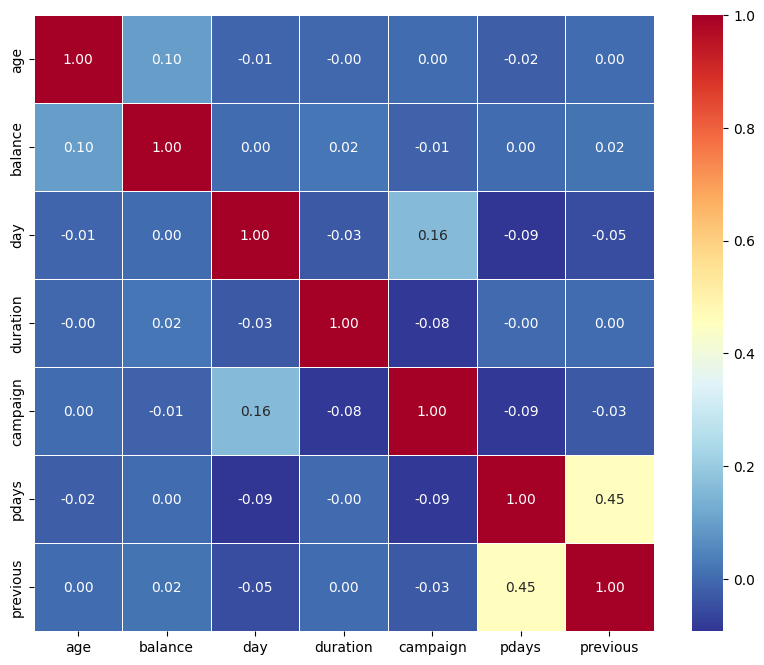

In [5]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, cmap='RdYlBu_r')
plt.show()

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True)

## Transformers

In [7]:
def encode_categorical(df_orginal, reverse=False):
    df = df_orginal.copy(deep=True)
    
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    month_num = {months[i]: i+1 for i in range(len(months))}
    month_num_reverse = {i+1: months[i] for i in range(len(months))}
    
    edu_num = {'tertiary':2, 'secondary':1, 'unknown':-1, 'primary':0}
    edu_num_reverse = {v: k for k, v in edu_num.items()}
    
    marital_num = {'single':0, 'married':1, 'divorced':2}
    marital_num_reverse = {v: k for k, v in marital_num.items()}
    
    # Encoding for binary columns
    binary_num = {"no":0 ,"yes":1}
    binary_num_reverse = {v: k for k, v in binary_num.items()}
    
    binaries = [col for col in df.columns if set(df[col].unique()) in [{"yes", "no"}, {0, 1}]]

    if reverse:
        df["month"] = df["month"].map(month_num_reverse)
        df["education"] = df["education"].map(edu_num_reverse)
        df["marital"] = df["marital"].map(marital_num_reverse)
        df[binaries] = df[binaries].apply(lambda x: x.map(binary_num_reverse))
        
    else:
        df["month"] = df["month"].map(month_num)
        df["education"] = df["education"].map(edu_num)
        df["marital"] = df["marital"].map(marital_num)
        df[binaries] = df[binaries].apply(lambda x: x.map(binary_num))
    
    df.columns = df.columns.str.replace('.', ' ') 
    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) == 0:
        print("All columns numeric")
    else:
        print("Non-numeric columns are: ", non_numeric_cols)
    
    return df

In [8]:
def calculate_woe(df, feature, target):
    total_events = df[target].sum()
    total_non_events = df.shape[0] - total_events

    groups = df.groupby(feature)[target].agg(['sum', 'count'])
    groups.columns = ['events', 'non_events']

    groups['events_rate'] = groups['events'] / total_events
    groups['non_events_rate'] = groups['non_events'] / total_non_events

    groups['woe'] = np.log(groups['events_rate'] / groups['non_events_rate'])
    groups['iv'] = (groups['events_rate'] - groups['non_events_rate']) * groups['woe']
    
    woe_dict = groups['woe'].to_dict()
    iv = groups['iv'].sum()
    
    return woe_dict, iv


In [9]:
def encode_woe(df, cols=df.columns.tolist(), target="y"):
    df = df.copy(deep=True)
    ivs = {}
    woe_dicts = {}
    for col in cols:
        woe_dict, iv = calculate_woe(df, col, target)
        ivs[col] = iv
        woe_dicts[col] = woe_dict
        df[col] = df[col].apply(lambda x: woe_dict.get(x, 0))
        
    return df, woe_dicts, ivs

In [10]:
def scaling(df, scaler=StandardScaler()):
    X_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
    return df_scaled, scaler

In [11]:
df_train_e = encode_categorical(df_train)

Non-numeric columns are:  Index(['job', 'contact', 'poutcome'], dtype='object')


<ipython-input-7-18aa86c3f8bb>:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', ' ')


In [12]:
df_train_e.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12308,43,blue-collar,1,0,0,720,0,0,unknown,25,6,168,8,-1,0,unknown,0
22145,44,technician,2,1,0,65,0,0,cellular,21,8,148,4,-1,0,unknown,0
22158,56,management,1,2,0,502,0,0,cellular,21,8,321,2,-1,0,unknown,0
39928,33,technician,2,2,0,0,1,0,cellular,2,6,72,1,-1,0,unknown,0
27729,59,management,1,2,0,2143,1,0,cellular,28,1,59,1,268,1,failure,0


In [13]:
# instead of one-hot encoding to not extend dataframe
df_train_woe, woe_dicts, ivs = encode_woe(df_train_e, ["job", "poutcome", "contact"], "y")

In [14]:
df_train_woe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12308,43,-0.632419,1,0,0,720,0,0,-1.178480,25,6,168,8,-1,0,-0.371820,0
22145,44,-0.213768,2,1,0,65,0,0,0.115975,21,8,148,4,-1,0,-0.371820,0
22158,56,0.052854,1,2,0,502,0,0,0.115975,21,8,321,2,-1,0,-0.371820,0
39928,33,-0.213768,2,2,0,0,1,0,0.115975,2,6,72,1,-1,0,-0.371820,0
27729,59,0.052854,1,2,0,2143,1,0,0.115975,28,1,59,1,268,1,-0.064734,0


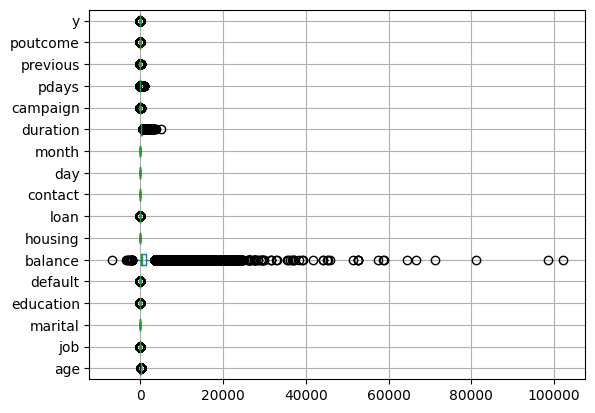

In [15]:
non_hot = [col for col in df_train_woe.columns if "_" not in col]
df_train_woe[non_hot].boxplot(vert=False)
plt.show()

In [16]:
df_train_scaled, scaler = scaling(df_train_woe)

In [17]:
df_train_scaled

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.195257,-1.329658,0.272559,-1.369247,-0.134946,-0.209053,-1.120278,-0.438101,-1.584904,1.103773,-0.063506,-0.351946,1.687838,-0.415536,-0.238402,-0.327641,-0.363079
1,0.289672,-0.087191,1.914610,-0.080623,-0.134946,-0.422508,-1.120278,-0.438101,0.646977,0.622966,0.763389,-0.430327,0.399915,-0.415536,-0.238402,-0.327641,-0.363079
2,1.422641,0.704085,0.272559,1.208001,-0.134946,-0.280096,-1.120278,-0.438101,0.646977,0.622966,0.763389,0.247666,-0.244047,-0.415536,-0.238402,-0.327641,-0.363079
3,-0.748884,-0.087191,1.914610,1.208001,-0.134946,-0.443690,0.892635,-0.438101,0.646977,-1.660867,-0.063506,-0.728173,-0.566028,-0.415536,-0.238402,-0.327641,-0.363079
4,1.705884,0.704085,0.272559,1.208001,-0.134946,0.254682,0.892635,-0.438101,0.646977,1.464378,-2.130744,-0.779121,-0.566028,2.273335,0.164477,0.491165,-0.363079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,-0.182399,-0.087191,0.272559,-0.080623,-0.134946,0.750027,-1.120278,-0.438101,0.646977,-0.579051,0.763389,-0.108966,0.077934,-0.415536,-0.238402,-0.327641,-0.363079
31643,1.517055,-0.557695,0.272559,-0.080623,-0.134946,-0.270971,0.892635,-0.438101,0.451609,-0.098244,-0.476953,-0.971153,1.365857,3.192949,2.581748,0.491165,-0.363079
31644,0.289672,0.322283,0.272559,-0.080623,-0.134946,-0.357005,0.892635,-0.438101,0.646977,0.142159,-0.890401,0.141852,-0.244047,-0.415536,-0.238402,-0.327641,-0.363079
31645,-0.560056,0.704085,-1.369491,1.208001,-0.134946,-0.433588,0.892635,-0.438101,0.646977,-0.218446,0.349942,-0.524384,0.077934,-0.415536,-0.238402,-0.327641,-0.363079


## K-means clustering method scaled data

In [18]:
def pca(p_df):
    # Apply PCA
    pca = PCA(n_components=0.8)   # 0.8 means 80% variance
    principalComponents = pca.fit_transform(p_df)
    df_r = pd.DataFrame(principalComponents, columns = ['principal_' + str(i) for i in range(1, pca.n_components_ + 1)])

    # Check the number of components
    print("Number of components = ", pca.n_components_)

    # Check the explained variance ratio
    print("Explained variance ratio = ", sum(pca.explained_variance_ratio_))
    
    return df_r

In [19]:
def count_wcss_scores(p_df, p_k):
    kmeans = KMeans(n_clusters = p_k, random_state = 0)
    kmeans.fit(p_df)
    return kmeans.score(p_df) * -1 # score returns -WCSS

In [20]:
def count_clustering_scores(p_df, p_cluster_num, p_model, p_score_fun):
    if isinstance(p_cluster_num, int):
        cluster_num_iter = [p_cluster_num]
    else:
        cluster_num_iter = p_cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = p_model(n_clusters = k)
        labels = model_instance.fit_predict(p_df)
        wcss = p_score_fun(p_df, labels)
        scores.append(wcss)
    
    if isinstance(p_cluster_num, int):
        return scores[0]
    else:
        return scores

In [21]:
def draw_elbow_wcss(p_df, p_k_max):
    cluster_num_seq = range(1, p_k_max)
    wcss_scores = []
    for k in cluster_num_seq:
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(p_df)
        wcss_scores.append(kmeans.score(p_df) * -1)
    plt.plot(cluster_num_seq, wcss_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('wcss score')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [22]:
def draw_elbow_shil(p_df, p_k_max):
    cluster_num_seq = range(2, p_k_max)
    silhouette_vec = count_clustering_scores(p_df, cluster_num_seq, KMeans, silhouette_score)
    plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [23]:
def cluster_KMeans(p_df, p_n_clusters):
    kmeans = KMeans(n_clusters = p_n_clusters, random_state = 0)

    # Fit the KMeans model to the data
    kmeans.fit(p_df)

    # Get the cluster assignments for each data point
    labels = kmeans.labels_

    # If you want to add the cluster labels back into your DataFrame
    p_df['cluster'] = labels

    print('Inertia:', kmeans.inertia_)

In [24]:
df_train_principal = pca(df_train_scaled)

Number of components =  12
Explained variance ratio =  0.8391727683442094


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

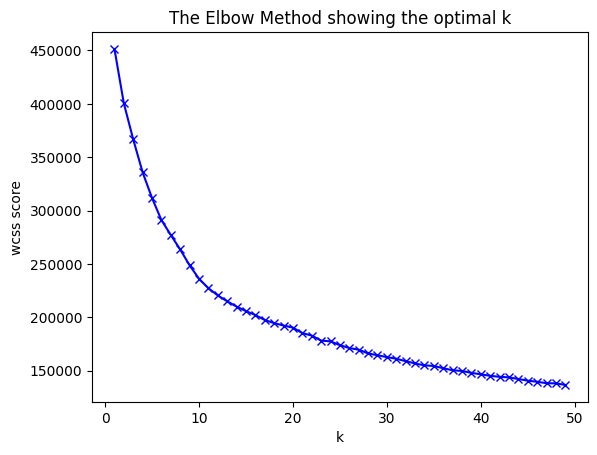

In [25]:
draw_elbow_wcss(df_train_principal, 50)

2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


13


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


20


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


22


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


23


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


24


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


25


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


26


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


27


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


28


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


29


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


30


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


31


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


32


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


33


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


34


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


35


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


36


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


37


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


38


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


39


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


40


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


41


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


42


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


43


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


44


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


45


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


46


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


47


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


48


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


49


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


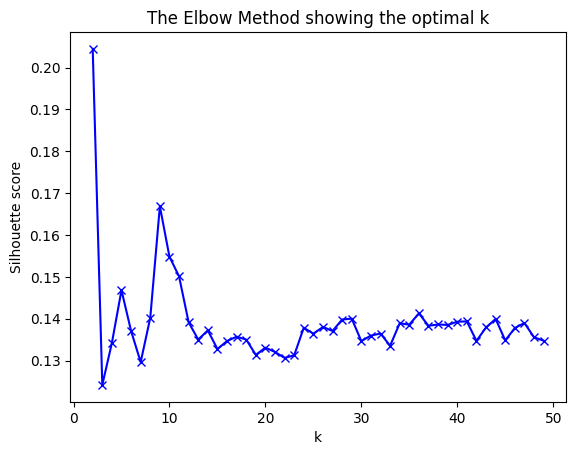

In [26]:
draw_elbow_shil(df_train_principal, 50)

In [27]:
cluster_KMeans(df_train_principal, 13)
df_train_c = df_train.copy(deep = True)
df_train_c['cluster'] = df_train_principal['cluster']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia: 215042.7576633662


## K-means clustering analysys

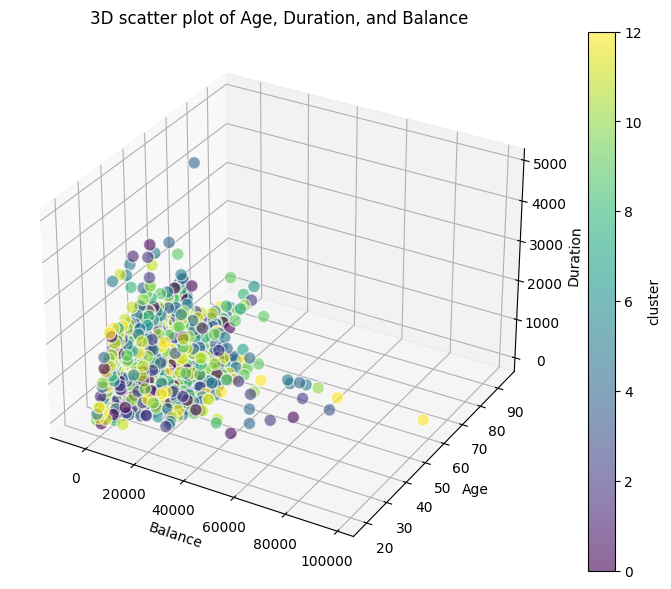

In [28]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_train_c['balance'], df_train_c['age'], df_train_c['duration'],   c=df_train_c['cluster'], alpha=0.6, edgecolors='w', s=80)

ax.set_xlabel('Balance')
ax.set_ylabel('Age')
ax.set_zlabel('Duration')

plt.colorbar(sc, label='cluster')  # Show color scale
plt.title('3D scatter plot of Age, Duration, and Balance')
plt.show()

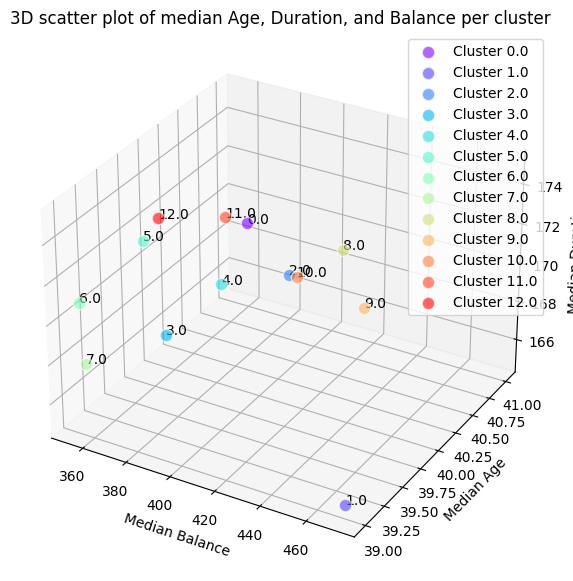

In [29]:
df_train_means = df_train_c.groupby('cluster')[['balance', 'age', 'duration']].median()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Get cluster labels and use as colors
clusters = df_train_means.index
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    ax.scatter(df_train_means.loc[cluster, 'balance'], df_train_means.loc[cluster, 'age'], df_train_means.loc[cluster, 'duration'], color=color, alpha=0.6, edgecolors='w', s=80, label='Cluster {}'.format(cluster))
    ax.text(df_train_means.loc[cluster, 'balance'], df_train_means.loc[cluster, 'age'], df_train_means.loc[cluster, 'duration'], '%s' % (str(cluster)), size=10, zorder=1, color='k')

ax.set_xlabel('Median Balance')
ax.set_ylabel('Median Age')
ax.set_zlabel('Median Duration')

plt.legend()
plt.title('3D scatter plot of median Age, Duration, and Balance per cluster')
plt.show()

In [30]:
# Get the most common jobs for each cluster
top_jobs = df_train_c.groupby('cluster')['job'].apply(lambda x: x.value_counts().nlargest(3))

# Convert the multi-index series to a dataframe
top_jobs_df = top_jobs.reset_index()

# Rename columns
top_jobs_df.columns = ['cluster', 'job', 'count']

# View the DataFrame
top_jobs_df.head()

,cluster,job,count
0,0.0,blue-collar,471
1,0.0,management,464
2,0.0,technician,383
3,1.0,blue-collar,73
4,1.0,management,67


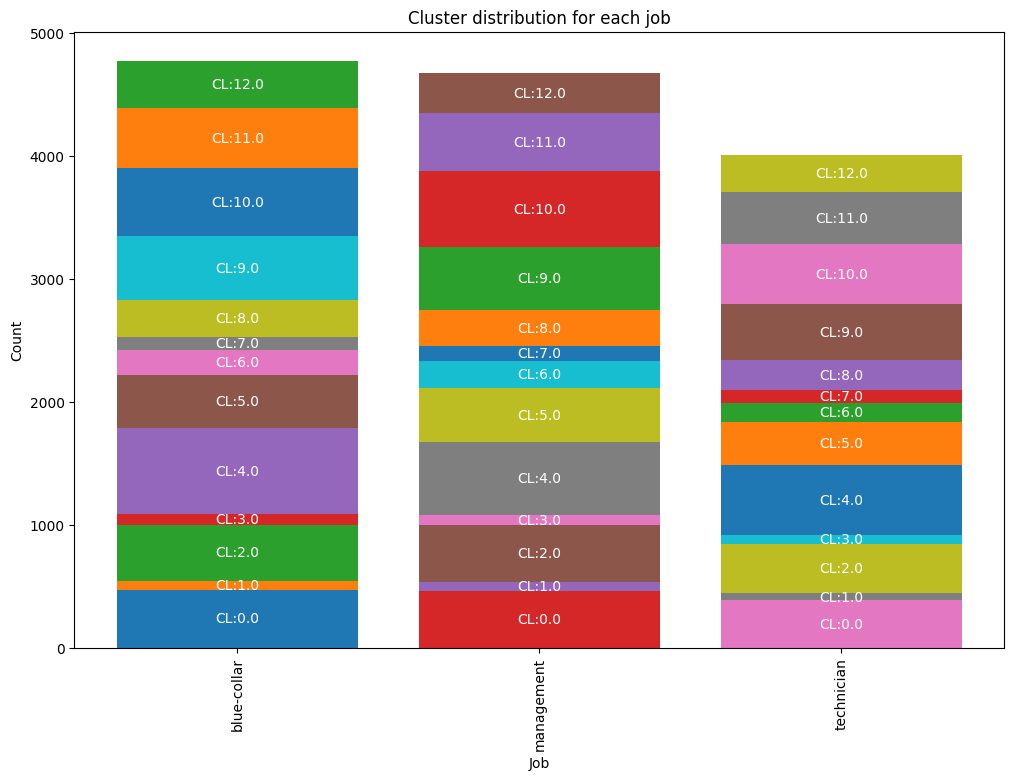

In [31]:
import matplotlib.pyplot as plt

# Get unique jobs and clusters
unique_jobs = top_jobs_df['job'].unique()
unique_clusters = top_jobs_df['cluster'].unique()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a bar for each job
for idx, job in enumerate(unique_jobs):
    # Get the counts for each cluster for the current job
    counts = top_jobs_df[top_jobs_df['job'] == job]['count']
    clusters = top_jobs_df[top_jobs_df['job'] == job]['cluster']

    # Create a bar for each cluster
    for cluster_idx, count in enumerate(counts):
        # If this is the first cluster, create the base of the bar
        if cluster_idx == 0:
            bar = ax.bar(idx, count)
        # If this is not the first cluster, add to the existing bar
        else:
            bar = ax.bar(idx, count, bottom=counts.iloc[:cluster_idx].sum())

        # Add the cluster number to the bar segment
        height = counts.iloc[:cluster_idx+1].sum()
        ax.text(idx, height - count/2, f'CL:{clusters.iloc[cluster_idx]}', ha='center', va='center', color='white')

# Set up the x-axis
ax.set_xticks(range(len(unique_jobs)))
ax.set_xticklabels(unique_jobs, rotation=90)

# Add labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Job')
ax.set_title('Cluster distribution for each job')

plt.show()

In [32]:
cluster_details = {
    0: "old_low_balance_retired",
    1: "housemaid",
    2: "middle_low_balance",
    3: "young_low_balance",
    4: "admin_management",
    5: "long_duration",
    6: 6,
    7: 7,
    8: "students",
    9: 8,
    10: 10,
    11:"high_balance",
    12: 12,
}

## hierarchy clustering

In [33]:
# my computer cannot operate on so many rows
df_t_r, _ = train_test_split(df_train, train_size=0.1, shuffle=True)

In [34]:
df_t_r.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
40506,38,unemployed,married,primary,no,7005,yes,no,cellular,7,jul,370,1,412,1,failure,yes
31807,32,management,single,tertiary,no,1781,no,no,cellular,8,apr,321,1,-1,0,unknown,yes
20819,51,technician,married,secondary,no,805,no,no,cellular,13,aug,270,2,-1,0,unknown,no
25350,51,management,divorced,tertiary,no,1937,yes,no,cellular,18,nov,185,4,152,11,other,no
26179,33,admin.,single,secondary,yes,-266,no,yes,cellular,20,nov,459,1,-1,0,unknown,no


In [35]:
df_t_r.shape

(3164, 17)

In [36]:
df_t_r_e = encode_categorical(df_t_r)

Non-numeric columns are:  Index(['job', 'contact', 'poutcome'], dtype='object')


<ipython-input-7-18aa86c3f8bb>:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', ' ')


In [37]:
df_t_r_e.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
40506,38,unemployed,1,0,0,7005,1,0,cellular,7,7,370,1,412,1,failure,1
31807,32,management,0,2,0,1781,0,0,cellular,8,4,321,1,-1,0,unknown,1
20819,51,technician,1,1,0,805,0,0,cellular,13,8,270,2,-1,0,unknown,0
25350,51,management,2,2,0,1937,1,0,cellular,18,11,185,4,152,11,other,0
26179,33,admin.,0,1,1,-266,0,1,cellular,20,11,459,1,-1,0,unknown,0


In [38]:
df_t_r_woe, woe_reduced_dicts, reduced_ivs = encode_woe(df_t_r_e, ["job", "poutcome", "contact"], "y")

In [39]:
df_t_r_woe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
40506,38,-0.005690,1,0,0,7005,1,0,0.135484,7,7,370,1,412,1,0.186406,1
31807,32,0.022278,0,2,0,1781,0,0,0.135484,8,4,321,1,-1,0,-0.377896,1
20819,51,-0.082006,1,1,0,805,0,0,0.135484,13,8,270,2,-1,0,-0.377896,0
25350,51,0.022278,2,2,0,1937,1,0,0.135484,18,11,185,4,152,11,-0.104035,0
26179,33,0.009624,0,1,1,-266,0,1,0.135484,20,11,459,1,-1,0,-0.377896,0


In [40]:
df_t_r_s, scaler = scaling(df_t_r_woe)

In [41]:
df_t_r_s.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,-0.266249,0.478300,0.28326,-1.362521,-0.148202,1.598726,0.892584,-0.448570,0.63544,-1.060760,0.347274,0.394477,-0.513206,3.732580,0.058976,1.129146,2.790858
1,-0.821016,0.540909,-1.37031,1.222022,-0.148202,0.100381,-1.120343,-0.448570,0.63544,-0.939512,-0.885919,0.211252,-0.513206,-0.414713,-0.131432,-0.363973,2.790858
2,0.935745,0.307460,0.28326,-0.070250,-0.148202,-0.179554,-1.120343,-0.448570,0.63544,-0.333276,0.758338,0.020549,-0.231201,-0.414713,-0.131432,-0.363973,-0.358313
3,0.935745,0.540909,1.93683,1.222022,-0.148202,0.145125,0.892584,-0.448570,0.63544,0.272959,1.991530,-0.297289,0.332809,1.121693,1.963053,0.360652,-0.358313
4,-0.728555,0.512582,-1.37031,-0.070250,6.747549,-0.486738,-1.120343,2.229307,0.63544,0.515454,1.991530,0.727272,-0.513206,-0.414713,-0.131432,-0.363973,-0.358313


In [42]:
df_t_r_pca = pca(df_t_r_s)

Number of components =  12
Explained variance ratio =  0.8397083934180871


In [43]:
df_t_r_pca.head()

,principal_1,principal_2,principal_3,principal_4,principal_5,principal_6,principal_7,principal_8,principal_9,principal_10,principal_11,principal_12
0,3.754365,1.161853,1.454617,-1.226210,-0.236978,1.096627,-0.775702,0.052629,0.649526,-0.935534,0.485910,-0.746659
1,1.791751,-0.431831,-2.303874,-1.389094,0.327422,-0.624874,-0.239850,0.695011,-0.428533,0.307434,0.321040,-0.279522
2,0.022703,-1.565016,0.456414,0.090011,0.336154,-0.288122,-0.553481,0.237589,-0.410471,0.330572,-0.632569,0.077899
3,1.290490,-0.593318,1.719942,1.569708,0.170409,0.050198,1.307166,-1.422551,1.145324,0.740158,-1.967671,-0.022453
4,-0.462964,-1.370201,-1.413369,1.626878,-3.687255,-3.466286,-1.022018,3.102629,3.737780,-1.335654,0.200502,0.471675


In [44]:
def c_dendrogram(p_df, p_method):
    mergings = linkage(p_df, method=p_method)
    dendrogram(mergings, leaf_rotation=90, leaf_font_size=2)
    plt.show()
    
    return mergings

In [45]:
def c_labels(p_mergings, p_fcluster_level):
    return fcluster(p_mergings, p_fcluster_level, criterion='distance')

In [46]:
def c_tsne(p_df, columns):
    for columns in columns:
        print(f"COLUMN '{columns}'")
        model_2d = TSNE(learning_rate=200)
        transformed = model_2d.fit_transform(p_df)
        xs = transformed[:, 0]
        ys = transformed[:, 1]
        plt.scatter(xs, ys, c=p_df[columns])
        plt.show()

        model_3d = TSNE(n_components=3, learning_rate=200)
        transformed = model_3d.fit_transform(p_df)
        xs = transformed[:, 0]
        ys = transformed[:, 1]
        zs = transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        sc = ax.scatter(xs, ys, zs, c=p_df[columns], alpha=0.6, edgecolors='w')
        plt.colorbar(sc, label='cluster')
        plt.show()
        print()


In [47]:
x = {}

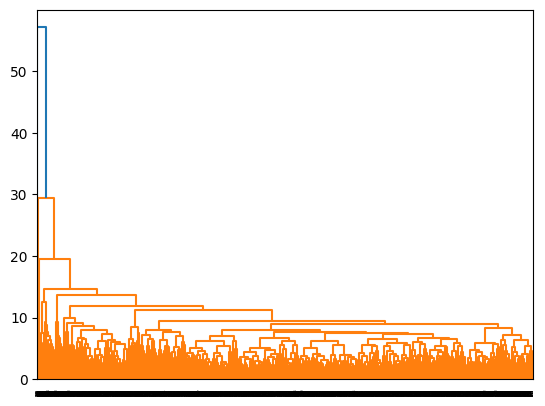

In [48]:
merg_complete = c_dendrogram(df_t_r_pca, 'complete')

In [49]:
df_t_r_s["labels_complete"] = c_labels(merg_complete, 10.5)

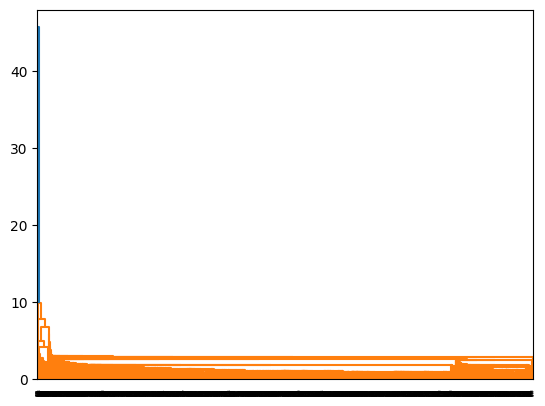

In [50]:
merg_single = c_dendrogram(df_t_r_pca, 'single')

In [51]:
df_t_r_s["labels_single"] = c_labels(merg_single, 5.5)

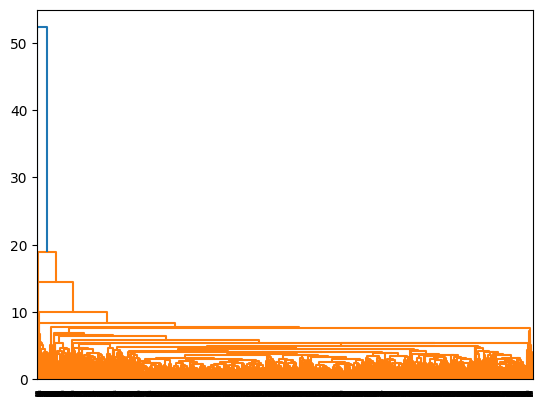

In [52]:
merg_average = c_dendrogram(df_t_r_pca, 'average')

In [53]:
df_t_r_s["labels_average"] = c_labels(merg_average, 7.75)

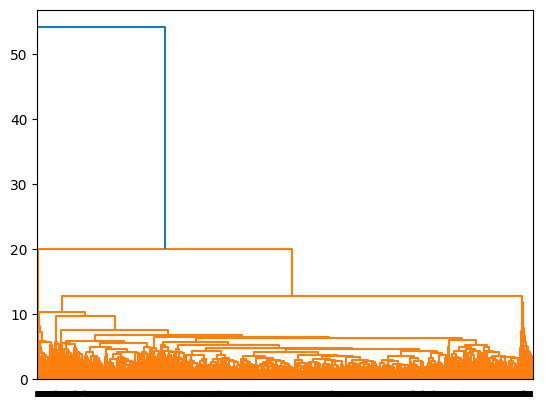

In [54]:
merg_weighted = c_dendrogram(df_t_r_pca, 'weighted')

In [55]:
df_t_r_s["labels_weighted"] = c_labels(merg_weighted, 8)

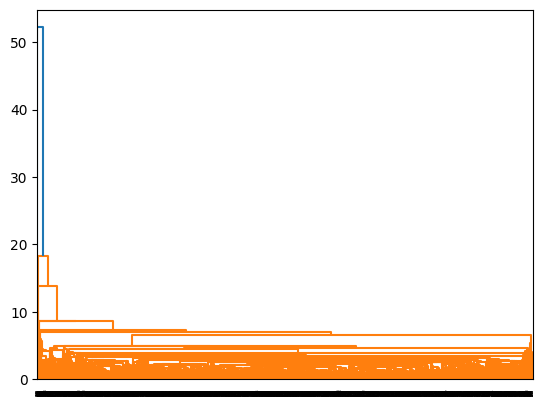

In [56]:
merg_centroid = c_dendrogram(df_t_r_pca, 'centroid')

In [57]:
df_t_r_s["labels_centroid"] = c_labels(merg_centroid, 6)

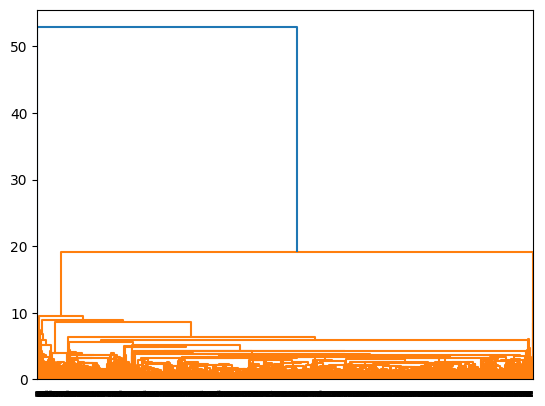

In [58]:
merg_median = c_dendrogram(df_t_r_pca, 'median')

In [59]:
df_t_r_s["labels_median"] = c_labels(merg_median, 6)

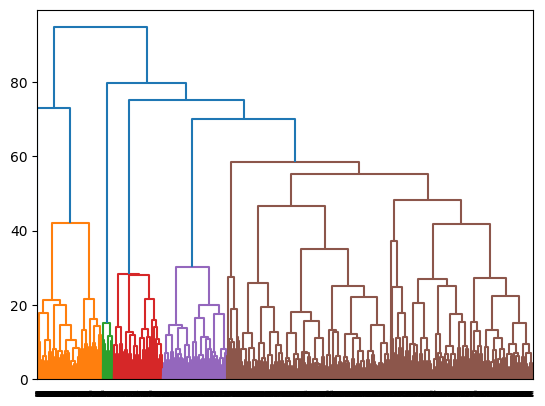

In [60]:
merg_ward = c_dendrogram(df_t_r_pca, 'ward')

In [61]:
df_t_r_s["labels_ward"] = c_labels(merg_ward, 15)

COLUMN 'labels_complete'


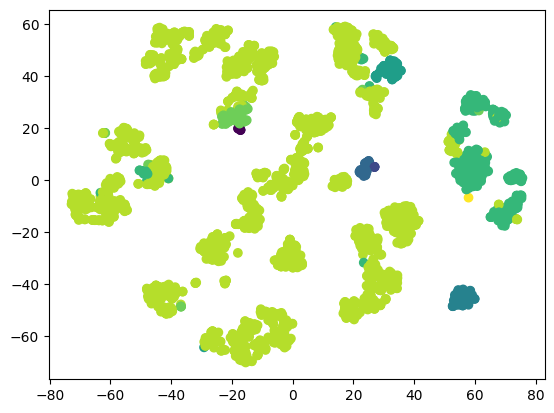

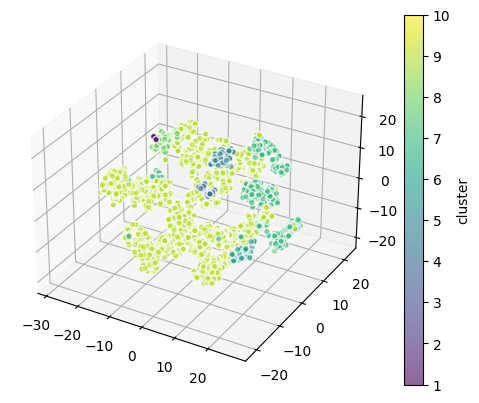


COLUMN 'labels_single'


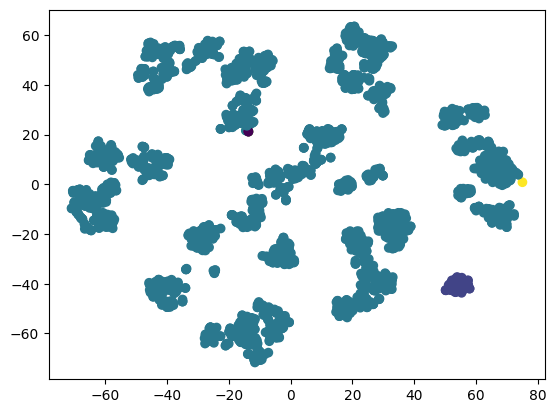

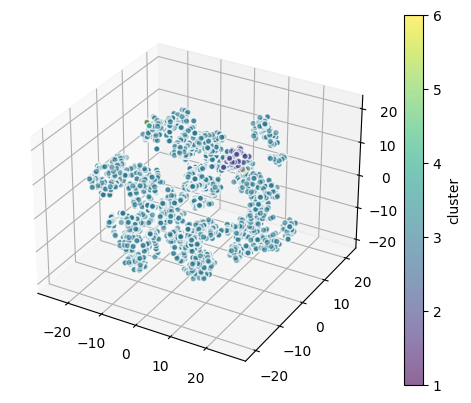


COLUMN 'labels_average'


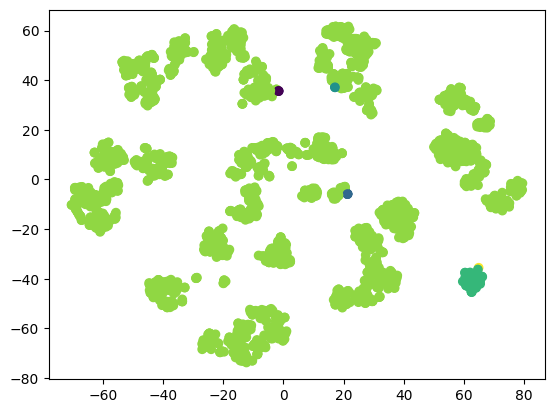

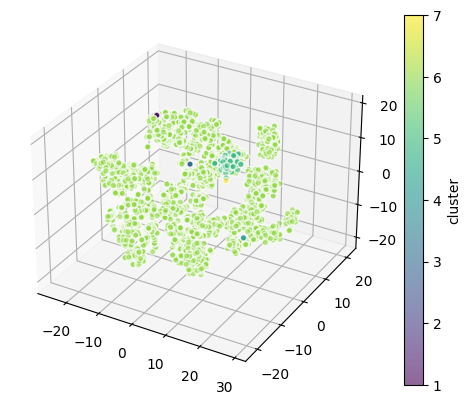


COLUMN 'labels_weighted'


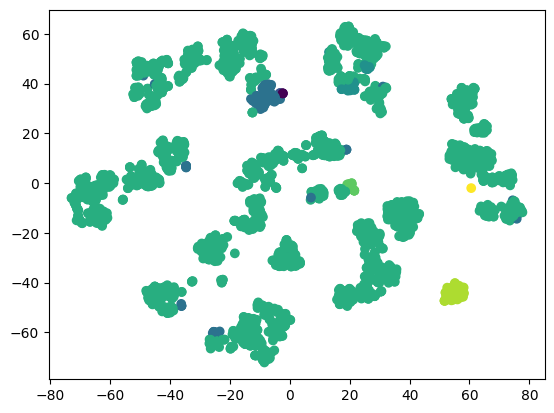

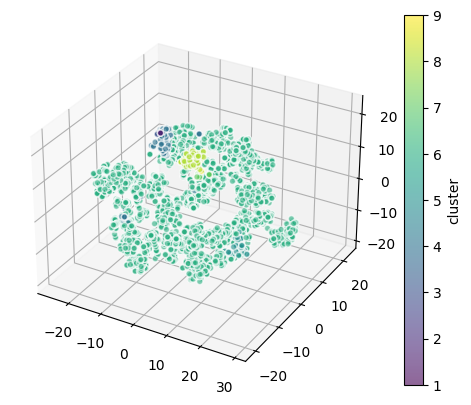


COLUMN 'labels_centroid'


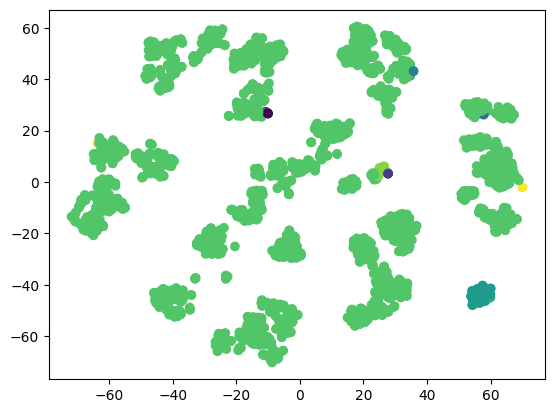

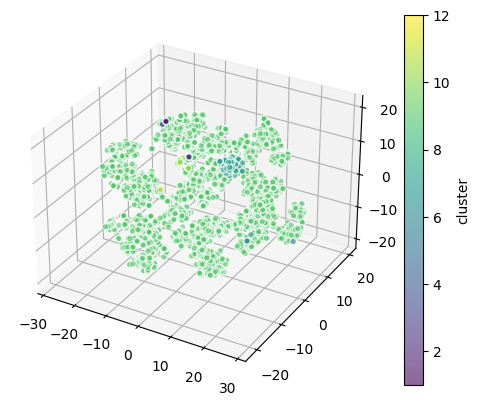


COLUMN 'labels_median'


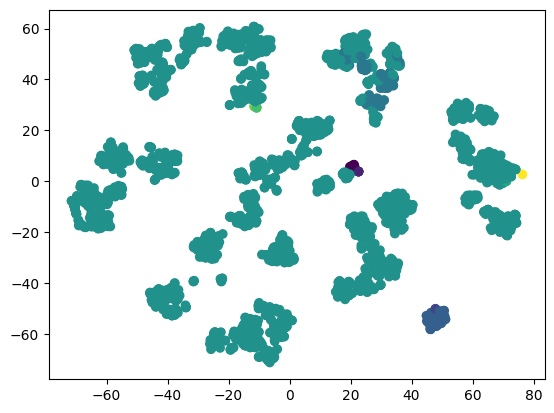

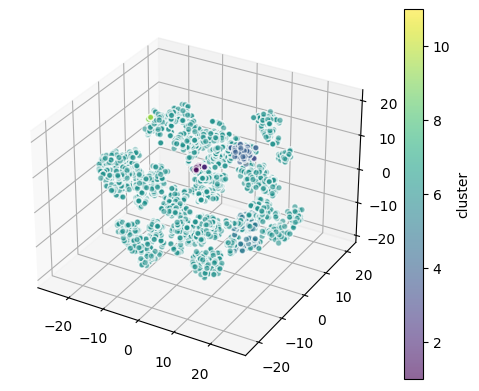


COLUMN 'labels_ward'


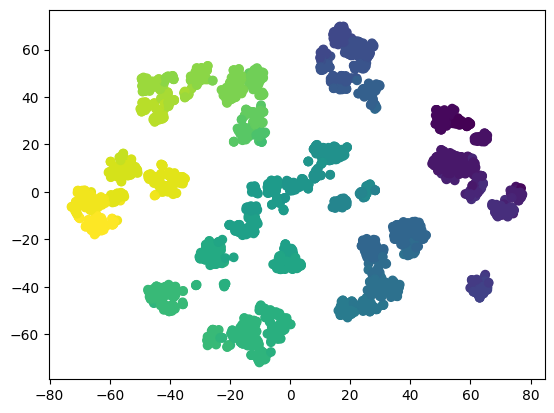

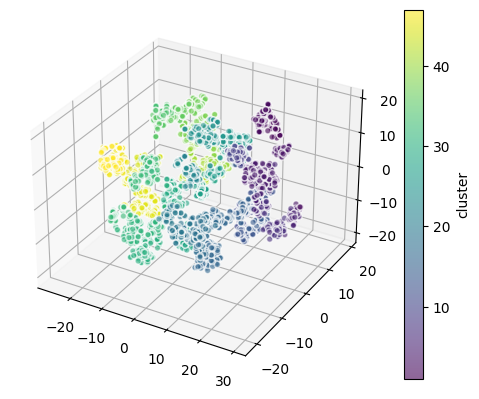

In [62]:
c_tsne(df_t_r_s, ["labels_complete",
                   "labels_single",
                   "labels_average",
                   "labels_weighted",
                   "labels_centroid",
                   "labels_median", 
                   "labels_ward"])

In [63]:
labels = [column for column in df_t_r_s.columns if column.startswith("labels_")]

In [64]:
for label in labels:
    print(f'in "{label}" column are {len(df_t_r_s[label].unique())} clusters')

in "labels_complete" column are 10 clusters
in "labels_single" column are 6 clusters
in "labels_average" column are 7 clusters
in "labels_weighted" column are 9 clusters
in "labels_centroid" column are 12 clusters
in "labels_median" column are 11 clusters
in "labels_ward" column are 47 clusters
